In [38]:
# Import our libraries.

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from itertools import combinations
import seaborn as sns

import matplotlib.pyplot as plt

carolinaBlue = 'deepskyblue'  # because d00k sucks

In [2]:
folder = "2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/"

# Formatting

Per the Kaggle Competition (https://www.kaggle.com/c/mens-machine-learning-competition-2019)

Submission for the ML competition are submitted as a prediction using the following format.

The resulting submission format looks like the following, where "pred" represents the predicted probability that the first team will win
id,pred
2014_1107_1110,0.5
2014_1107_1112,0.5 
2014_1107_1113,0.5

yyyy_WTeamID_LTeamID, predicted_probability

# LogLoss Evaluation

https://www.kaggle.com/c/mens-machine-learning-competition-2019/overview/evaluation

Kaggle uses a LogLoss to evaluate the submissions.



In [3]:
# running logloss on a test set

test_label = [1,1,0,0,1,1,0,0]
test_predicted = [.5,.5,.5,.5,.5,.5,.5,.5]

log_loss(test_label, test_predicted, eps = 1e-15)

0.6931471805599453

In [4]:
# ok, so we need to pass in an array of 1's and 0's based on whether we were right.
# and then pass in our confidence.


# Creating a Baseline

I figured a good baseline to try to beat is running a model where the higher seed won every game.

In [5]:
# Load Data.
Results = pd.read_csv(folder + "MNCAATourneyCompactResults.csv")
df_Seeds = pd.read_csv(folder + "MNCAATourneySeeds.csv")

In [6]:
# we need a quick and dirty function to convert Seed from its current format to an int.
 
def convertSeed(seed):
    '''Convert Seed from String to Int.
     so "W01" --> is 1, with the advent of the play in games, 
     we only care about 2nd and 3rd positions in the string.'''
    
    return (int(seed[1:3]))

In [7]:
# run conversion

df_Seeds['SeedInt'] = df_Seeds['Seed'].apply(convertSeed)

In [8]:
print(df_Seeds.head(2))
print(Results.head(2))

   Season Seed  TeamID  SeedInt
0    1985  W01    1207        1
1    1985  W02    1210        2
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0


We need to convert the seeds into an comparable integer and then merge the two databases together.


In [9]:
# split our two df's.  Rename once for winning seeds, once for losing seeds.
# every now and then I wish we had a nice vlookup in pandas.

winners = df_Seeds.rename(columns = {'TeamID':'WTeamID', 'SeedInt':'WSeed'}) 
df_merged = pd.merge(left = Results, right = winners, how = 'left', 
                    on=['Season', 'WTeamID' ])

losers = df_Seeds.rename(columns = {'TeamID':'LTeamID', 'SeedInt':'LSeed'}) 
df_merged = pd.merge(left = df_merged, right = losers, how = 'left', 
                    on=['Season', 'LTeamID' ])

# dropping more useless columns post merge

df_merged = df_merged.drop(columns=['Seed_x', 'Seed_y'])

In [10]:
# HWin is our target, 1 if lower(better) seed won
# we will use a 50% predicted probability as baseline

df_merged['Hwin'] = (df_merged['WSeed']<=df_merged['LSeed'])
df_merged['Pred_50'] = 0.50
df_merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,Hwin,Pred_50
0,1985,136,1116,63,1234,54,N,0,9,8,False,0.5
1,1985,136,1120,59,1345,58,N,0,11,6,False,0.5
2,1985,136,1207,68,1250,43,N,0,1,16,True,0.5
3,1985,136,1229,58,1425,55,N,0,9,8,False,0.5
4,1985,136,1242,49,1325,38,N,0,3,14,True,0.5


In [11]:
# lets see how that scores over last 10 years
for i in range(2010, 2020):
    score = df_merged[df_merged['Season']==i]
    print(str(i) + " : " + str(log_loss(score['Hwin'], score['Pred_50'], eps = 1e-15)))

2010 : 0.6931471805599453
2011 : 0.6931471805599454
2012 : 0.6931471805599454
2013 : 0.6931471805599454
2014 : 0.6931471805599454
2015 : 0.6931471805599454
2016 : 0.6931471805599454
2017 : 0.6931471805599454
2018 : 0.6931471805599454
2019 : 0.6931471805599454


In [12]:
pred_2019 = df_merged[df_merged['Season']==2019].drop(columns=['Season', 'DayNum', 'WTeamID', 
                                                               'WScore', 'LTeamID', 'LScore', 'WLoc',
                                                               'NumOT', 'WSeed', 'LSeed'])

In [13]:
# create inputs to chart LogLoss 

x = []
y = []
for i in np.arange(.05 , .95 , 0.025):
    pred_2019['Pred_50'] = i
    x.append(i)
    y.append(log_loss(pred_2019['Hwin'], pred_2019['Pred_50'], eps = 1e-15))

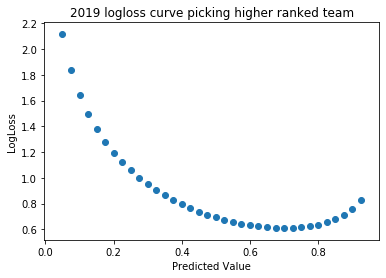

In [14]:

plt.scatter(x, y)
plt.title('2019 logloss curve picking higher ranked team')
plt.ylabel('LogLoss')
plt.xlabel('Predicted Value')
plt.show()

# Predictions

Using Seed Differential
Using Per Game Stats

In [15]:
# basic stats - seed Differential

# we need to add columns for seed differential and absolute value of 
# seed diff so we can calculate the win % given the delta

df_merged['seed_diff'] = df_merged['WSeed'] - df_merged['LSeed']
df_merged['abs_seed_diff'] = abs(df_merged['seed_diff'])

df_merged.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,Hwin,Pred_50,seed_diff,abs_seed_diff
0,1985,136,1116,63,1234,54,N,0,9,8,False,0.5,1,1
1,1985,136,1120,59,1345,58,N,0,11,6,False,0.5,5,5
2,1985,136,1207,68,1250,43,N,0,1,16,True,0.5,-15,15
3,1985,136,1229,58,1425,55,N,0,9,8,False,0.5,1,1
4,1985,136,1242,49,1325,38,N,0,3,14,True,0.5,-11,11


In [16]:
# putting winrates into a table we can use later.
win_rates = []

for i in df_merged['abs_seed_diff'].unique():
    if i==0:
        win_rates.append([i, 0.5])
    else:
        win_rates.append([i, 1 - len(df_merged[df_merged['seed_diff'] == i])/len(df_merged[df_merged['abs_seed_diff'] == i])])

df_win = pd.DataFrame(win_rates,  columns=['abs_seed_diff', 'win_rate'])
df_win.head()

,abs_seed_diff,win_rate
0,1,0.539510
1,5,0.669388
2,15,0.992857
3,11,0.868750
4,7,0.694690


In [17]:
df = pd.merge(df_merged, df_win, on='abs_seed_diff')


In [19]:
log_loss(test_2019['Hwin'], test_2019['win_rate'], eps = 1e-15)

0.5156821636852087

In [53]:
# lets see how adding a seed diff confidence interval changes our scores over last 10 years
years = range(2010,2020)
score = []
score_seed = []
for i in range(2010, 2020):
    temp_df = df[df['Season']==i]
    score.append(log_loss(temp_df['Hwin'], temp_df['Pred_50'], eps = 1e-15))
    score_seed.append(log_loss(temp_df['Hwin'], temp_df['win_rate'], eps = 1e-15))
    #print(str(i) + " Score Improvement: " +str(round(score - score_seed, 3)*100) + "% : " + str(score) + str(score_seed) )
    

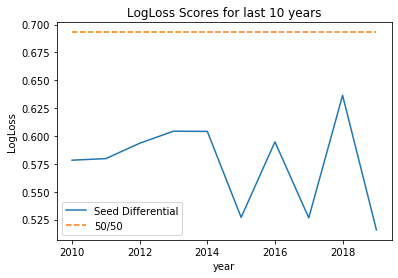

In [64]:
fig, ax = plt.subplots()
ax.plot(years, score_seed, label = "Seed Differential")
ax.plot(years, score, '--', label = "50/50")

plt.title('LogLoss Scores for last 10 years')
plt.ylabel('LogLoss')
plt.xlabel('year')
plt.legend(loc="best")
plt.show()

# Using our classifier to create a better model?


# Output File

In [21]:
# create our team list

teams_2019 = df_Seeds[df_Seeds['Season']==2019]['TeamID'].values
teams_2019

array([1181, 1277, 1261, 1439, 1280, 1268, 1257, 1433, 1416, 1278, 1125,
       1396, 1251, 1387, 1463, 1133, 1295, 1300, 1211, 1276, 1403, 1199,
       1266, 1138, 1305, 1393, 1124, 1196, 1113, 1385, 1293, 1436, 1297,
       1285, 1192, 1341, 1314, 1246, 1222, 1242, 1120, 1235, 1459, 1429,
       1449, 1371, 1326, 1308, 1318, 1209, 1101, 1233, 1438, 1397, 1345,
       1243, 1458, 1437, 1153, 1279, 1328, 1234, 1388, 1332, 1414, 1330,
       1159, 1205], dtype=int64)

In [22]:
# create matchup matrix of all teams.

def output_matrix(teams, year):
    '''
    takes in an array of teams that are participating in the tournament in the specified year.
    
    returns our prediction using the kaggle submission format with higher seeded team first and 0.5 probability.
    
    '''
    output = []
    comb = combinations(teams, 2)
    for i in list(comb):
        output.append([return_higher_seed(i[0], i[1], year), 0.5])
    return (output)

In [23]:
# determine higher seed
def return_higher_seed(TeamID1, TeamID2, year):
    '''
    takes in 2 teams, and the season (year) in which they are being compared
    
    returns in string format (year_team1_team2) where team1 is the higher seeded team
    '''
    
    seed1 = df_Seeds.loc[(df_Seeds['Season']==year) & (df_Seeds['TeamID']==TeamID1)]['SeedInt'].values[0]
    seed2 = df_Seeds.loc[(df_Seeds['Season']==year) & (df_Seeds['TeamID']==TeamID2)]['SeedInt'].values[0]
    if seed1 >= seed2:
        return (str(year) + "_" + str(TeamID1) + "_" + str(TeamID2))
    else:
        return (str(year) + "_" + str(TeamID2) + "_" +  str(TeamID1))

In [24]:
output_2019 = output_matrix(teams_2019, 2019)
